# 프로젝트 소개 - 개인 : 퍼셉트론 수의 영향 알아보기

Kaggle Fish Dataseset을 가지고 다양한 조건으로 최상의 분류모델 찾기
- 데이터셋 : Fish Data

- batch_size = 50
- epoch = 30
- 조기 종료 조건 : F1 기준 갱신 5번 이하
- learning_rate = default
- 최적화 함수 → Adam
- 배치 정규화 → 각 레이어마다
- 가중치 초기화 → He
- train : validation = 6 : 1
- test는 팀원 개인 글씨

## 1. 모듈 로딩 

In [1]:
from PIL import Image
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import torch # torch 기본 모듈로 텐서 기본 함수들 
import torch.nn as nn # linear Regression 기능의 클래스 Linear
import torch.nn.functional as F # 손실함수를 위함
import torch.optim as optim # 최적화를 위함

In [2]:
seed = 2024

np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed_all(seed)


## 2. 데이터 준비

In [3]:
torch.manual_seed(seed)
torch.randint(1, 5, (3, 3))

tensor([[1, 3, 1],
        [1, 4, 1],
        [3, 4, 2]])

In [4]:
# 지워도 됨
import os

dir_path = "Fish_Dataset"

file_list = os.listdir(dir_path)
file_list

['Black Sea Sprat',
 'Gilt-Head Bream',
 'Hourse Mackerel',
 'Red Mullet',
 'Red Sea Bream',
 'Sea Bass',
 'Shrimp',
 'Striped Red Mullet',
 'Trout']

In [5]:
feature = pd.read_pickle("feature2.pkl")
target = pd.read_pickle("target2.pkl")

In [6]:
# 데이터 피쳐와 타겟 개수 확인 
print(f"feare: {feature.shape}, {feature.ndim}D")
print(f"target: {target.shape}, {target.ndim}D")
# feature 15000개

feare: (9000, 2655), 2D
target: (9000, 1), 2D


In [7]:
feature.iloc[0,:].value_counts()

0
0    2404
1     251
Name: count, dtype: int64

In [8]:
target.value_counts()

0    1000
1    1000
2    1000
3    1000
4    1000
5    1000
6    1000
7    1000
8    1000
Name: count, dtype: int64

In [9]:
target = target[0] # 타겟 1차원으로 만들기!!

## 3. 데이터 가공 및 전처리
- 결측치 없음
- 이상치 없음
- 중복값 없음 
- 정규화 필요 없음
- 타겟 -> one-hot encoding

In [10]:
# one-hot encoding : scatter_
idx = torch.IntTensor(target.astype("int")).type(torch.int64).unsqueeze(1)

y_one_hot = torch.zeros(target.shape[0], len(target.unique())) # len(target.unique()) => 물고기 종류 9개
y_one_hot = y_one_hot.scatter_(1, idx, 1).type(torch.int64) # 차원, 1.0이 들어갈 자리 인덱스, 채울 숫자

## 4. 데이터 분할 및 데이터셋 준비
- 텐서화 시키기
- 데이터 셋 준비 : 훈련용 60000, 테스트용 10000
- 학습 방법 : 지도 학습 - 이진 분류 (softmax->but cross_entropy가 다 갖고 있음)
- 최적화 방법 : 경사하강법 기반의 방법 (Adam, SDG, )
- 손실함수 : 이진분류 손실 계산 함수(cross_entropy)

### 4-1 데이터 분할

In [11]:
from torch.utils.data import Dataset, DataLoader, TensorDataset
from sklearn.model_selection import train_test_split

In [12]:
x_train, x_test, y_train, y_test = train_test_split(feature, y_one_hot, test_size=0.1, random_state=42, stratify=target)

In [13]:
x_val, x_test, y_val, y_test = train_test_split(x_test, y_test, test_size=0.1, random_state=42, stratify=y_test)

In [14]:
# 데이터 shape 확인
print(f"train data => {x_train.shape}, {y_train.shape}")
print(f"valindation data => {x_val.shape}, {y_val.shape}")
print(f"test data => {x_test.shape}, {y_test.shape}")

# 8100
# 810
# 90

train data => (8100, 2655), torch.Size([8100, 9])
valindation data => (810, 2655), torch.Size([810, 9])
test data => (90, 2655), torch.Size([90, 9])


### 4-2 데이터 셋 생성

In [15]:
# 사용자 정의 DataSet Class
# 데이터의 텐서변환
class DLDataset(Dataset): # torch.utils.data.Dataset을 부모로 두는 class 생성
    # 초기화 함수
    def __init__(self, x_data, y_data):
        # print(y_data.dtype)
        super().__init__()
        
        # x 데이터 => ndarray
        if isinstance(x_data, torch.Tensor):
            pass
        else:
            x_data = x_data.values if isinstance(x_data, pd.DataFrame) else x_data # 데이터 프레임이라면 valuse로 어레이 뽑아줘야함 
            
        # y 데이터 => ndarray
        if isinstance(y_data, torch.Tensor):
            pass
        else:
            y_data = y_data.values if isinstance(y_data, pd.DataFrame) else y_data 
        # ndarray에서 tensor로 변환 
        
        self.feature = torch.FloatTensor(x_data)
        self.target = torch.LongTensor(y_data) 
        # print("[target & feature SHAPE]", self.target.shape, self.target.ndim)
    
    # 데이터셋의 개수 체크 함수
    def __len__(self):
        return self.target.shape[0]
    
    # 특정 인덱스 데이터 + 라벨 반환 callback function 
    def __getitem__(self, index):
        return self.feature[index], self.target[index] # 둘 다 튜플로 출동 

In [16]:
train_data = DLDataset(x_train, y_train) # numpy, numpy
val_data = DLDataset(x_val, y_val) # numpy, numpy
test_data = DLDataset(x_test, y_test) # numpy, numpy

In [17]:
# from torch.utils.data import random_split
# 
# seed = torch.Generator().manual_seed(42)
# trainDS, validDS = random_split(my_dataset, [60000, 10000], generator=seed) 
# 
# print(f"trainDS => {len(trainDS)}개\nvalidDS => {len(validDS)}개")

In [18]:
# DataLoader 생성

BATCH_SIZE = 50
trainDL = DataLoader(train_data, batch_size=BATCH_SIZE, drop_last=False, shuffle=True)
validDL = DataLoader(val_data, batch_size=BATCH_SIZE, drop_last=False, shuffle=True)
testDL = DataLoader(test_data, batch_size=BATCH_SIZE, drop_last=False, shuffle=True) # false 해놓으면 쪼가리들 나중에 쓸 수 있음

print(f"[나눠진 배치 개수]\ntrainDL => {len(trainDL)}\nvalidDL => {len(validDL)}\ntestDL => {len(testDL)}")

[나눠진 배치 개수]
trainDL => 162
validDL => 17
testDL => 2


## 5. 학습
- 조기 종료 조건 넣기
- 코드 좀 더 유연하게 수정하기
- 배치 정규화 -> 각 레이어마다
- 가중치 초기화 -> He

### 5-1 모델 생성

In [19]:
temp_feature, temp_label = next(iter(trainDL))

In [20]:
temp_feature.shape[1], temp_label.shape[1] # 각각의 1번 요소를 뽑으면 IN_DIM, OUT_DIM

(2655, 9)

In [21]:
# MyModel 클래스 생성 : 내 미션은 퍼셉트론 수 영향 알아보기 
class MyModel(nn.Module):
    
    # 모델 구성 요소 초기화 
    def __init__(self, in_dim, out_dim, layer_num, perceptron_nums):
        super().__init__()
        self.layer_num = layer_num
        self.in_dim = in_dim
        self.out_dim = out_dim
        
        self.layers = nn.ModuleList()  # ModuleList에 layer 담기
        idx = 0
        # 은닉층과 활성화 함수 추가
        for i in range(len(perceptron_nums)-2):
            self.layers.append(nn.Linear(perceptron_nums[i], perceptron_nums[i+1]))  # 선형 레이어 추가
            self.layers.append(nn.ReLU())  # ReLU 활성화 함수 추가
            # in_dim = out_dim  # 다음 레이어의 입력 차원을 현재 출력 차원으로 설정
            idx = i
            
        # 출력층 추가
        self.layers.append(nn.Linear(perceptron_nums[idx+1], out_dim))
        
    def forward(self, x):
        # 각 레이어를 차례로 통과시킴
        for layer in self.layers:
            x = layer(x)
        return x

### 5-2. 학습 함수, 예측 함수 생성, 실행디바이스, 모델, 최적화, 손실함수, 학습 횟수

In [22]:
# 실행 디바이스 설정
DEVICE = "cuda" if torch.cuda.is_available() else "cpu" # GPU있으면 쓰고 없으면 cpu로

# 모델 생성!!!!!!!!!!!!!!!!!!!!!

In [23]:
# 모델 인스턴스 생성
IN_DIM = temp_feature.shape[1] # 입력 피쳐 수
OUT_DIM = temp_label.shape[1] # 출력 피쳐 수
HIDDEN_NUM = 1 # 히든 레이어 개수 나는 0개!! 퍼셉트론 수 조절 하기  

perceptron_nums = list(np.linspace(IN_DIM, OUT_DIM, HIDDEN_NUM+2, dtype=int))



model = MyModel(IN_DIM, OUT_DIM, HIDDEN_NUM+2, perceptron_nums).to(DEVICE)

In [24]:
# 가중치 초기화
for layer in model.layers:
    print(f"{layer} => nn.Linear T/F? {isinstance(layer, nn.Linear)}")
    print()
    if isinstance(layer, nn.Linear) == True:
        nn.init.xavier_uniform_(layer.weight)

Linear(in_features=2655, out_features=1332, bias=True) => nn.Linear T/F? True

ReLU() => nn.Linear T/F? False

Linear(in_features=1332, out_features=9, bias=True) => nn.Linear T/F? True


In [25]:
# 손실함수 인스턴스 생성
LOSS_FN = nn.CrossEntropyLoss().to(DEVICE) # 다중분류니까

# 최적화 인스턴스 생성
OPTIMIZER = optim.Adam(model.parameters()) # lr = default 사용

# 반복 횟수
EPOCHS = 30

In [26]:
# 그래프 전용 함수 
def plt_graph(loss_accuracy):
    fig, ax1 = plt.subplots()
    ax1.plot(loss_accuracy[0], label='loss', color="g")
    
    ax2 = ax1.twinx()
    ax2.plot(loss_accuracy[1],label='accuracy', color='r')
    # plt.plot(loss_accuracy[0], label='loss')
    # plt.plot(loss_accuracy[1], label='accuracy')
    
    ax1.legend(loc='upper left')
    ax2.legend(loc='upper right')
    
    plt.xlabel("Epochs")
    plt.show()

In [27]:
from sklearn.metrics import f1_score

In [28]:
# 학습 진행 함수
def training():
    # 학습 모드 전환 함수 : dropout이나 batch normalization과 같은 레이어들이 학습할 때의 동작 모드
    model.train()
    
    # 배치크기 만큼 학습 진행 및 저장 
    train_loss = []
    train_f1 = []
    
    for cnt, (feature, target) in enumerate(trainDL):

        # 배치크기만큼의 학습 데이터 준비 
        feature, target = feature.to(DEVICE), target.to(DEVICE)
        target = target.squeeze().type(torch.float32)

        # 학습 
        pre_target = model(feature)
        # print(f"pre_target => {pre_target.shape}, {pre_target.ndim}D")
        # print(f"target => {target.shape}, {target.ndim}D")
        
        # 손실계산
        loss = LOSS_FN(pre_target, target)
        train_loss.append(loss.item())
        
        # W, b 업데이트
        OPTIMIZER.zero_grad() # 초기화
        loss.backward() 
        OPTIMIZER.step()
        
        # print(pre_target.max(dim=1).indices)
        # print(target.max(dim=1).indices)
        
        f1 = f1_score(pre_target.max(dim=1).indices,target.max(dim=1).indices, average="macro")
                #(pre_target.max(dim=1).indices == target.max(dim=1).indices).sum() / len(pre_target))
        # print(f"acc => {acc}")

        train_f1.append(f1)
        # 배치 단위 학습 진행 메시지 출력 
        # print(f"[train batch loss] => {loss}")
        
    # 학습 진행 메시지 출력
    # print(f"[Train loss] ==> {loss}, [acc] ==> {acc}")
    
    return np.mean(train_loss), np.mean(train_f1)

In [29]:
# 검증 및 평가 진행 함수
# 매개변수 dataLoader : 검증 또는 테스트 데이터 셋에 대한 Loader 
def testing():
    # 추론 모드 : 레이어 비활성화, 순전파만!! 수행
    model.eval()
    
    with torch.no_grad():
        # 배치크기 만큼 학습 진행 및 저장 
        val_loss = []
        val_f1 = []
        for cnt, (feature, target) in enumerate(validDL):
            # print(cnt, feature, target)
            # 배치크기만큼의 학습 데이터 준비 
            feature, target = feature.to(DEVICE), target.to(DEVICE)
            target = target.squeeze().type(torch.float32)
        
            # 학습 
            pre_target = model(feature)
            # print(f"pre_target => {pre_target.shape}, {pre_target.ndim}D")
            # print(f"target => {target.shape}, {target.ndim}D")
            
            # 손실계산
            loss = LOSS_FN(pre_target, target)
            val_loss.append(loss.item())
            
            f1 = f1_score(pre_target.max(dim=1).indices,target.max(dim=1).indices, average="macro")
            
            val_f1.append(f1)
            
    
    # 학습 진행 메시지 출력
    
    # print(f"acc => {acc}") 
    # print(f"[Valid loss] ==> {loss}, [acc] ==> {acc}")
    
    return np.mean(val_loss), np.mean(val_f1)

0 improve_cnt => 0
Best valid => 0.5523
1 improve_cnt => 0
2 improve_cnt => 1
Best valid => 0.6277
3 improve_cnt => 0
Best valid => 0.6458
4 improve_cnt => 0
Best valid => 0.648
5 improve_cnt => 0
Best valid => 0.6686
6 improve_cnt => 0
Best valid => 0.7046
7 improve_cnt => 0
Best valid => 0.7134
8 improve_cnt => 0
Best valid => 0.7192
9 improve_cnt => 0
10 improve_cnt => 1
Best valid => 0.7358
11 improve_cnt => 0
Best valid => 0.7567
12 improve_cnt => 0
13 improve_cnt => 1
14 improve_cnt => 2
15 improve_cnt => 3
16 improve_cnt => 4
Early stopping at epoch 16


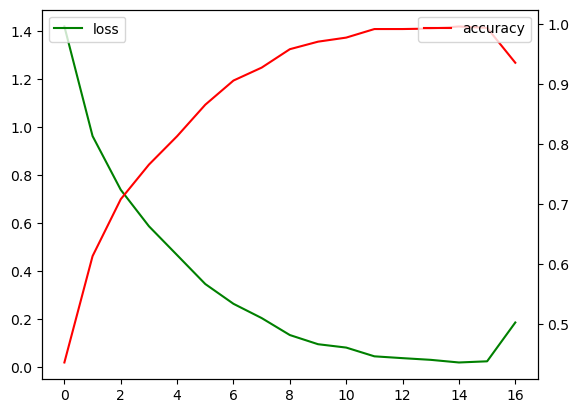

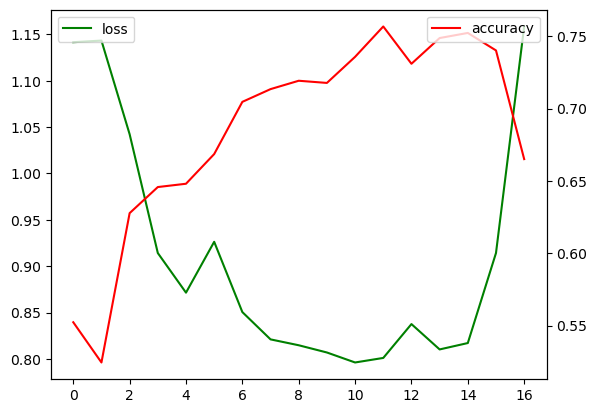

In [30]:
# 지정된 횟수 만큼 처음부터 ~ 끝까지 학습 및 검증 진행 
# 목표 : 최적(Error 최소화)의 W, b를 가진 모델 완성 

# from torch.optim.lr_scheduler import ReduceLROnPlateau
best_valid_f1 = float('-inf')
patience = 5
improve_cnt = 0

train_loss_f1 = [[],[]]
val_loss_f1 = [[],[]]

for eps in range(EPOCHS):
    train_loss, train_f1 = training() # 학습
    train_loss_f1[0].append(train_loss)
    train_loss_f1[1].append(train_f1)
    
    valid_loss, val_f1 = testing() # 검증 
    val_loss_f1[0].append(valid_loss)
    val_loss_f1[1].append(val_f1)
    
    # print(f"[{eps}/{EPOCHS}] \nTRAIN {sum(train_loss)/len(train_loss)} \nVALID : {sum(valid_loss)/len(valid_loss)}\n\n")
    print(eps, f"improve_cnt => {improve_cnt}")
    
    if val_f1 > best_valid_f1:
        best_valid_f1 = round(val_f1, 4)
        improve_cnt = 0
        print(f"Best valid => {best_valid_f1}")
    else:
        improve_cnt += 1
        if improve_cnt >= patience:
            print(f"Early stopping at epoch {eps}")
            break
    
            
plt_graph(train_loss_f1)
plt_graph(val_loss_f1)

# 예측 진행

In [31]:
def prediction():
    # prediction에는 loss 필요없다
    # 추론 모드 => 정규화, 경사하강법, 드랍아웃 등의 기능 비활성화
    model.eval()
    
    with torch.no_grad():
        # 배치크기 만큼 학습 진행 및 저장 
        pred_acc = []
        for cnt, (feature, target) in enumerate(testDL):
            
            feature, target = feature.to(DEVICE), target.to(DEVICE)
            target = target.squeeze().type(torch.float32)
        
            # 학습 
            pre_target = model(feature)
            # print(f"pre_target => {pre_target.shape}, {pre_target.ndim}D")
            # print(f"target => {target.shape}, {target.ndim}D")
            
            
            acc = (pre_target.max(dim=1).indices == target.max(dim=1).indices).sum() / len(pre_target)
            pred_acc.append(acc)
            
    return np.mean(pred_acc)

In [32]:
p_f1 = prediction()
print(f"predict accuracy => {p_f1:.4f}")

predict accuracy => 0.6575


In [40]:
#######################퍼셉트론 개수 전용
perceptron_list = [] # [[IN_DIM, 100, OUT_DIM], [IN_DIM, 200, OUT_DIM]]
for i in range(100, 4000, 500):
    temp = [IN_DIM, i, OUT_DIM]
    perceptron_list.append(temp)
#######################################

perceptron_f1_list = [[], []]
train_loss_f1_list = []
val_loss_f1_list = []

for perceptron_nums in perceptron_list:
    model = MyModel(IN_DIM, OUT_DIM, HIDDEN_NUM+2, perceptron_nums).to(DEVICE)
    
    # 가중치 초기화
    for layer in model.layers:
        # print(f"{layer} => nn.Linear T/F? {isinstance(layer, nn.Linear)}")
        # print()
        if isinstance(layer, nn.Linear) == True:
            nn.init.xavier_uniform_(layer.weight)
            
    # 손실함수 인스턴스 생성
    LOSS_FN = nn.CrossEntropyLoss().to(DEVICE) # 다중분류니까
    
    # 최적화 인스턴스 생성
    OPTIMIZER = optim.Adam(model.parameters()) # lr = default 사용
    
    # 반복 횟수
    EPOCHS = 30
    
    best_valid_f1 = float('-inf')
    patience = 5
    improve_cnt = 0
    
    train_loss_f1 = [[],[]]
    val_loss_f1 = [[],[]]
    
    for eps in range(EPOCHS):
        train_loss, train_f1 = training() # 학습
        train_loss_f1[0].append(train_loss)
        train_loss_f1[1].append(train_f1)
        
        valid_loss, val_f1 = testing() # 검증 
        val_loss_f1[0].append(valid_loss)
        val_loss_f1[1].append(val_f1)
        
        # print(f"[{eps}/{EPOCHS}] \nTRAIN {sum(train_loss)/len(train_loss)} \nVALID : {sum(valid_loss)/len(valid_loss)}\n\n")
        # print(eps, f"improve_cnt => {improve_cnt}")
        
        if val_f1 > best_valid_f1:
            best_valid_f1 = round(val_f1, 4)
            improve_cnt = 0
            # print(f"Best valid => {best_valid_f1}")
        else:
            improve_cnt += 1
            if improve_cnt >= patience:
                # print(f"Early stopping at epoch {eps}")
                break
        
    # plt_graph(train_loss_f1)
    # plt_graph(val_loss_f1)
    train_loss_f1_list.append(train_loss_f1)
    val_loss_f1_list.append(val_loss_f1)
    
    p_f1 = prediction()
    print(perceptron_nums)
    print(f"predict f1_score => {p_f1:.4f}")
    torch.save(model, f'../data/model/mymodel{perceptron_nums[1]}.pt')
    perceptron_f1_list[0].append(perceptron_nums[1])
    perceptron_f1_list[1].append(p_f1)

[2655, 100, 9]
predict f1_score => 0.6675
[2655, 600, 9]
predict f1_score => 0.7250
[2655, 1100, 9]
predict f1_score => 0.7225
[2655, 1600, 9]
predict f1_score => 0.5900
[2655, 2100, 9]
predict f1_score => 0.7125
[2655, 2600, 9]
predict f1_score => 0.7500
[2655, 3100, 9]
predict f1_score => 0.6550
[2655, 3600, 9]
predict f1_score => 0.6900


=> 단순히 퍼셉트론 수만 바꾸는 것은 의미가 없는 것 같음!! 

In [41]:
# plt_graph(perceptron_f1_list)

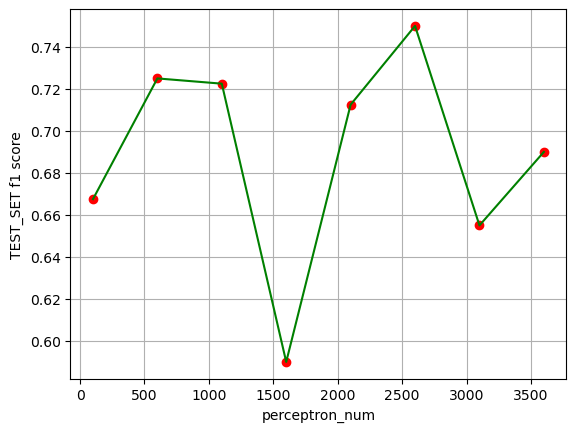

In [44]:
fig, ax1 = plt.subplots()
ax1.plot(perceptron_f1_list[0], perceptron_f1_list[1], label='loss', color="g")

ax1.scatter(perceptron_f1_list[0], perceptron_f1_list[1], color='r', label='data points')

# plt.plot(loss_accuracy[0], label='loss')
# plt.plot(loss_accuracy[1], label='accuracy')

# ax1.legend(loc='upper left')
# ax2.legend(loc='upper right')

plt.ylabel("TEST_SET f1 score")
plt.xlabel("perceptron_num")
plt.grid()
plt.show()